## 1 . import Data from csv file


In [350]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


- Calendar.csv : including listing id and the price and availability for that day
- Listings.csv : including full descriptions and average review score


In [351]:
df_calendar_b_origin = pd.read_csv("./data/Boston/calendar.csv")
df_listing_b_origin = pd.read_csv("./data/Boston/listings.csv")


## 2 . clean up the listing data


In [352]:
display(df_listing_b_origin.sample(3))


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2957,14822087,https://www.airbnb.com/rooms/14822087,20160906204935,2016-09-07,Best futon in town!,"Our cozzy, cute apartment is just what you wan...",Our home is the cozziest place. Is the second ...,"Our cozzy, cute apartment is just what you wan...",none,Theres some very nice and delicious restaurant...,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN
1692,1541166,https://www.airbnb.com/rooms/1541166,20160906204935,2016-09-07,Beautiful Studio 15 min to Downtown,"Come stay in our beautiful studio, close to ev...",Twin size sofa bed (we provide an additional m...,"Come stay in our beautiful studio, close to ev...",none,NaN,...,10.0,f,NaN,NaN,f,moderate,f,f,1,0.45
1475,14422439,https://www.airbnb.com/rooms/14422439,20160906204935,2016-09-07,Beautiful Condo in Boston's Back Bay GS2,This is a beautiful property in Boston's Back ...,Our latest Boston vacation rental combines the...,This is a beautiful property in Boston's Back ...,none,"In the heart of Boston's Downtown, Back Bay! N...",...,NaN,f,NaN,NaN,f,strict,f,f,25,NaN


In [353]:
df_listing_b_origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

### 2.1 get the columns with special inof

- high missingvalue
- one single unique value
- just recors url/id/name
- just true/false


In [354]:
def get_sub_columns_list(df, missing_ratio_cutoff):
    high_missing_cols = []
    missing_ratios = []
    single_value_cols = []
    single_values = []
    url_cols = []
    tf_cols = []  # true false nan

    total_listings = df.shape[0]
    tf_set = {"t", "f", np.nan}
    for col in df.columns:
        missing_ratio = round(df[col].isnull().sum() / total_listings, 2)

        if len((df[col]).unique()) == 1:
            single_value_cols = single_value_cols + [col]
            single_values = single_values + [(df[col]).unique()]
        elif missing_ratio >= missing_ratio_cutoff:
            high_missing_cols = high_missing_cols + [col]
            missing_ratios = missing_ratios + [missing_ratio]
        elif "url" in col or "_id" in col or "name" in col:
            url_cols = url_cols + [col]
        elif len((df[col]).unique()) <= 3 and set((df[col]).unique()).issubset(tf_set):
            tf_cols.append(col)

    print("tf_cols : {} ".format(len(tf_cols)))
    for col in tf_cols:
        print("    col {} has t/f values".format(col))

    print("high_missing_cols : {} ".format(len(high_missing_cols)))
    for col, missing_ratio in zip(high_missing_cols, missing_ratios):
        print('    col "{}" missing value ratio is {}:'.format(col, missing_ratio))

    print("single_value_cols : {} ".format(len(single_value_cols)))
    for col, val in zip(single_value_cols, single_values):
        print('    col "{}" has a single unique value {}:'.format(col, val))

    print("url_cols : {} ".format(len(url_cols)))
    for col in url_cols:
        print('    col "{}" records id, name or url.'.format(col))

    return tf_cols, high_missing_cols, single_value_cols, url_cols


In [355]:
(
    tf_cols,
    high_missing_cols,
    single_value_cols,
    url_cols,
) = get_sub_columns_list(df_listing_b_origin, 0.5)


tf_cols : 6 
    col host_is_superhost has t/f values
    col host_has_profile_pic has t/f values
    col is_location_exact has t/f values
    col instant_bookable has t/f values
    col require_guest_profile_picture has t/f values
    col require_guest_phone_verification has t/f values
high_missing_cols : 5 
    col "notes" missing value ratio is 0.55:
    col "square_feet" missing value ratio is 0.98:
    col "weekly_price" missing value ratio is 0.75:
    col "monthly_price" missing value ratio is 0.75:
    col "security_deposit" missing value ratio is 0.63:
single_value_cols : 12 
    col "scrape_id" has a single unique value [20160906204935]:
    col "last_scraped" has a single unique value ['2016-09-07']:
    col "experiences_offered" has a single unique value ['none']:
    col "neighbourhood_group_cleansed" has a single unique value [nan]:
    col "state" has a single unique value ['MA']:
    col "country_code" has a single unique value ['US']:
    col "country" has a single uni

### 2.2 delete these columns

- high missingvalue
- one single unique value
- just recors url/id/name
- other irrelevant columns


In [356]:
drop_cols = high_missing_cols + single_value_cols + url_cols
df_listing_b = df_listing_b_origin.drop(columns=drop_cols)


### 2.3 transfer t/f to 1/0


In [357]:
def chg_col_tf_to_01(x):
    return 1 if x == "t" else 0


display(df_listing_b[tf_cols].sample(5))
df_listing_b[tf_cols] = df_listing_b[tf_cols].applymap(chg_col_tf_to_01)
display(df_listing_b[tf_cols].sample(5))

,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
1887,t,t,t,f,f,f
3435,f,t,t,f,f,f
1087,t,t,f,f,f,f
3393,f,t,t,f,f,f
418,t,t,t,f,f,f


,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
609,0,1,1,0,0,0
1492,0,1,1,0,0,0
2383,0,1,1,1,0,0
1258,0,1,1,0,0,1
699,0,1,1,0,0,0


### 2.4 transfer date to year


In [358]:
display(df_listing_b["host_since"].sample(3))
df_listing_b["host_since_years"] = (
    2018 - pd.to_datetime(df_listing_b["host_since"]).dt.year
)
df_listing_b = df_listing_b.drop(columns=["host_since"])
display(df_listing_b["host_since_years"].sample(3))


2747    2013-09-04
138     2015-11-19
1263    2011-04-14
Name: host_since, dtype: object

340     4
3025    4
2755    3
Name: host_since_years, dtype: int64

### 2.5 transfer rate to float


In [359]:
change_string_to_float_cols = ["host_response_rate", "host_acceptance_rate"]
display(df_listing_b[change_string_to_float_cols].sample(3))


def chg_col_rate_str_to_float(col):
    return col.str.strip("%").astype(float)


df_listing_b[change_string_to_float_cols] = df_listing_b[
    change_string_to_float_cols
].apply(chg_col_rate_str_to_float)
display(df_listing_b[change_string_to_float_cols].sample(3))


,host_response_rate,host_acceptance_rate
2424,75%,74%
2339,98%,55%
2693,100%,99%


,host_response_rate,host_acceptance_rate
2702,61.0,100.0
1544,94.0,69.0
372,100.0,100.0


### 2.6 transfer response time from category to int


In [360]:
display(df_listing_b["host_response_time"].sample(3))
rsps_time_map = {
    "within an hour": 1,
    "within a few hours": 4,
    "within a day ": 24,
    "a few days or more": 48,
}
df_listing_b["host_response_time"] = df_listing_b["host_response_time"].map(
    rsps_time_map
)
display(df_listing_b["host_response_time"].sample(3))


3489                   NaN
1647    within a few hours
1295    within a few hours
Name: host_response_time, dtype: object

1077    4.0
2420    NaN
421     1.0
Name: host_response_time, dtype: float64

### 2.7 transfer description(string) to character counts(int)


In [361]:
# Define description features
description_features = [
    "summary",
    "space",
    "description",
    "neighborhood_overview",
    "transit",
    "access",
    "interaction",
    "house_rules",
    "host_about",
]

display(df_listing_b[description_features].sample(3))

# Convert null values to empty strings
df_listing_b[description_features] = df_listing_b[description_features].apply(
    lambda col: col.fillna(""), axis=1
)

# Convert description features to character counts
for column in df_listing_b[description_features]:
    df_listing_b[column] = df_listing_b[column].apply(lambda x: len(x))

display(df_listing_b[description_features].sample(3))


,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about
2300,We are young students living and working in Bo...,Our studio is cozy and comfortable. Wrap aroun...,We are young students living and working in Bo...,Fun and safe neighborhood in the Fenway area. ...,NaN,Access to laundry and trash room in the basement.,NaN,NaN,NaN
2851,"步行3-5分钟到红线地铁JFK站,","坐地铁到唐人街约15分钟,到哈佛大学约35分钟,两条线均可到达","步行3-5分钟到红线地铁JFK站, 坐地铁到唐人街约15分钟,到哈佛大学约35分钟,两条线均...","整洁,安静,安全,","交通非常便利,红线地铁JFK, UMass 站",冰箱和微波炉,有需要可随时交流,"不抽烟,不带宠物,不能带其他人入屋",NaN
2487,"1860's brownstone townhouse: comfortable, sunn...",The elegant brownstone townhouse has 10+ foot ...,"1860's brownstone townhouse: comfortable, sunn...",Just steps away from the Charles River and eas...,Public transportation is around the corner on ...,Guests will have access to all common areas in...,Having spent much time in the hospitality indu...,"This is a quiet, long-standing residential com...","Originally from New Jersey, I fell in love wit..."


,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about
2610,174,327,1000,205,624,87,203,169,326
2025,94,1000,1000,143,0,0,0,11,866
2417,304,0,604,171,32,80,13,106,0


### 2.8 transfer amenities(string) to amenities count(int)


In [362]:
display(df_listing_b["amenities"].sample(3))

df_listing_b["amenities_count"] = df_listing_b.amenities.str.count(",") + 1
df_listing_b = df_listing_b.drop(columns=["amenities"], axis=1)

display(df_listing_b["amenities_count"].sample(3))


2101    {TV,"Cable TV",Internet,"Wireless Internet","A...
3499    {TV,"Cable TV",Internet,"Wireless Internet","A...
1768    {TV,"Wireless Internet","Air Conditioning",Kit...
Name: amenities, dtype: object

1698    10
943     24
2815     8
Name: amenities_count, dtype: int64

### 2.9 drop irrelevant columns


In [363]:
irrelevant_cols = [
    "host_location",
    "host_listings_count",
    "calculated_host_listings_count",
    "host_verifications",
    "host_neighbourhood",
    "is_location_exact",
    "host_has_profile_pic",
    "neighbourhood",
    "city",
    "smart_location",
    "street",
    "first_review",
    "availability_30",
    "bed_type",
    "availability_60",
    "availability_90",
    "availability_365",
    "host_neighbourhood",
    "host_total_listings_count",
    "review_scores_location",
    "zipcode",
    "market",
    "smart_location",
    "latitude",
    "longitude",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "calendar_updated",
    "last_review",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
]
df_listing_b = df_listing_b.drop(columns=irrelevant_cols)

### 2.10 visualize the data


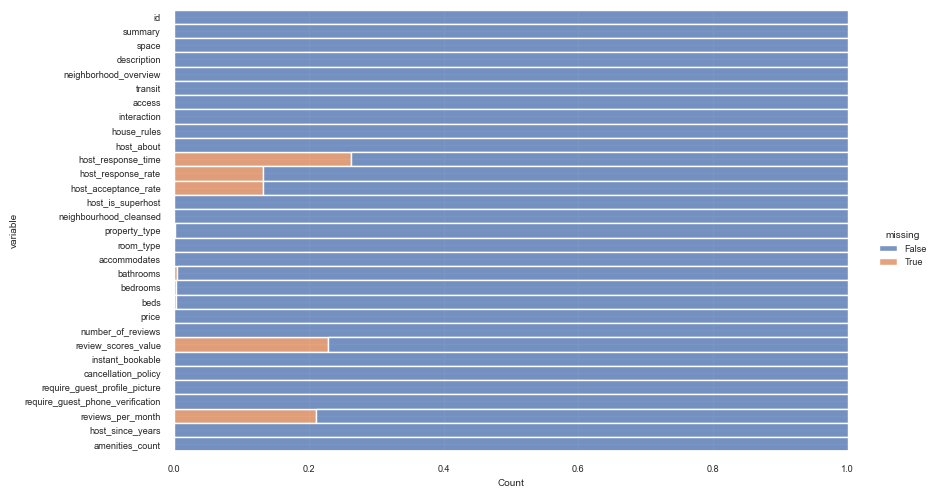

In [364]:
# visualize missing values
sns.set(font_scale=0.6)
sns.displot(
    data=df_listing_b.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.75,
)


<Axes: >

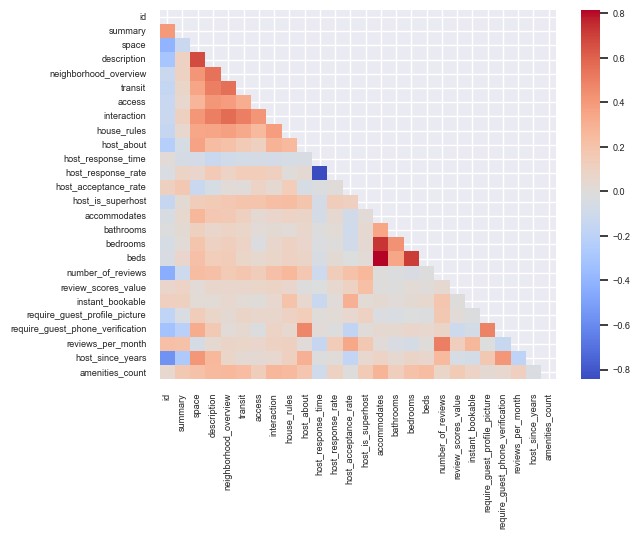

In [365]:
# visualize correlation
corr = df_listing_b.select_dtypes(exclude="object").corr()
matrix = np.triu(corr)
sns.heatmap(corr, cmap="coolwarm", annot=False, mask=matrix)


## 3 . clean up the calendar data


In [366]:
display(df_calendar_b_origin.sample(3))


,listing_id,date,available,price
936991,8518237,2017-07-18,f,NaN
83361,1631942,2017-01-04,f,NaN
529599,2331886,2016-09-21,f,NaN


In [367]:
df_calendar_b_origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [368]:
# drop rows without price
df_calendar_b = df_calendar_b_origin.dropna(subset=["price"], axis=0).copy()


# convert price from string to float
def chg_col_dollar_str_to_float(val):
    return float(val.replace("$", "").replace(",", ""))


df_calendar_b["price"] = df_calendar_b["price"].apply(chg_col_dollar_str_to_float)

# get the month from date and remove the date column
df_calendar_b["month"] = df_calendar_b["date"].apply(
    lambda value: datetime.datetime.strptime(value, "%Y-%m-%d").strftime("%b")
)

df_calendar_b.drop(columns=["date", "available"], inplace=True)

In [369]:
df_calendar_b.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   listing_id  643037 non-null  int64  
 1   price       643037 non-null  float64
 2   month       643037 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 19.6+ MB


In [370]:
display(df_calendar_b.sample(3))


,listing_id,price,month
194236,4518710,165.0,May
375641,5582163,170.0,Apr
651492,10118573,422.0,Oct


## 4 . merge these two DataFrames into one


In [371]:
df_b = (
    pd.merge(
        df_listing_b, df_calendar_b, how="left", left_on="id", right_on="listing_id"
    )
    .drop(["price_x", "listing_id"], axis=1)
    .rename({"price_y": "price"}, axis=1)
    .dropna(subset=["price"])
)


display(df_b.sample(5))


,id,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about,...,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_since_years,amenities_count,price,month
243802,1372816,0,794,794,0,0,0,0,10,866,...,9.0,0,super_strict_30,0,1,0.17,9,8,209.0,Dec
461023,7310887,246,218,1000,323,192,32,90,290,430,...,10.0,0,flexible,0,0,5.33,3,19,285.0,Aug
490125,3839678,233,225,1000,239,347,357,209,89,251,...,9.0,0,moderate,0,0,0.40,5,15,50.0,Nov
121359,4924910,295,1000,1000,1000,493,288,761,361,577,...,9.0,0,strict,0,0,5.78,4,11,165.0,Jan
182990,9728602,246,358,1000,329,426,93,133,191,399,...,10.0,0,flexible,0,0,0.24,6,13,266.0,Jan


## 5 . Exploring the data for trending


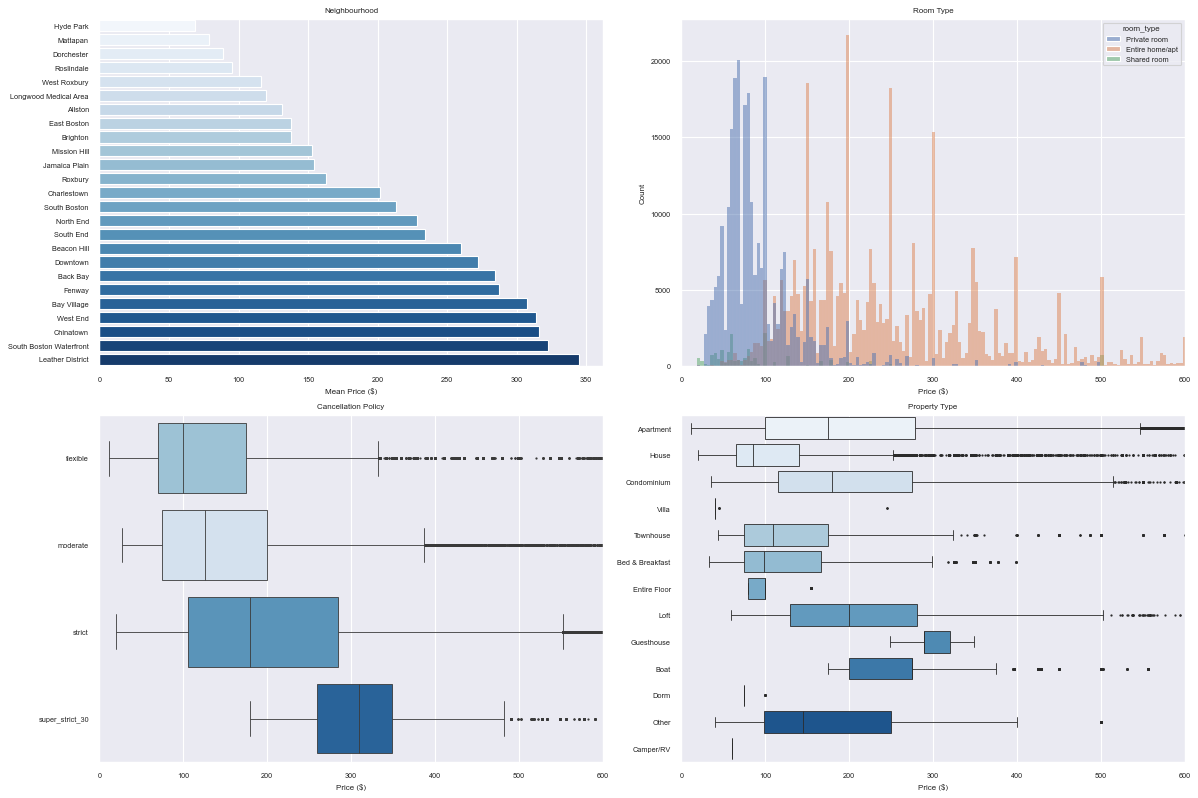

In [372]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=80)

# Neighbourhoods
df_neighbourhoods = (
    df_b.groupby("neighbourhood_cleansed").agg({"price": np.mean}).reset_index()
)
sns.barplot(
    x="price",
    y="neighbourhood_cleansed",
    hue="neighbourhood_cleansed",
    data=df_neighbourhoods.sort_values("price"),
    orient="h",
    palette="Blues",
    ax=axs[0, 0],
    legend=False,
)
axs[0, 0].set_title("Neighbourhood")
axs[0, 0].set_xlabel("Mean Price ($)")
axs[0, 0].set_ylabel("")

# Room type
sns.histplot(x="price", hue="room_type", data=df_b, ax=axs[0, 1])
axs[0, 1].set_xlim(0, 600)
axs[0, 1].set_title("Room Type")
axs[0, 1].set_xlabel("Price ($)")
axs[1, 0].set_ylabel("count")

# Cancellation Policy
sns.boxplot(
    x="price",
    y="cancellation_policy",
    hue="cancellation_policy",
    fliersize=1,
    linewidth=0.75,
    data=df_b,
    palette="Blues",
    ax=axs[1, 0],
    order=["flexible", "moderate", "strict", "super_strict_30"],
)
axs[1, 0].set_xlim(0, 600)
axs[1, 0].set_title("Cancellation Policy")
axs[1, 0].set_xlabel("Price ($)")
axs[1, 0].set_ylabel("")

# Property type
sns.boxplot(
    x="price",
    y="property_type",
    hue="property_type",
    fliersize=1,
    linewidth=0.75,
    data=df_b,
    palette="Blues",
    ax=axs[1, 1],
    legend=False,
)
axs[1, 1].set_xlim(0, 600)
axs[1, 1].set_title("Property Type")
axs[1, 1].set_xlabel("Price ($)")
axs[1, 1].set_ylabel("")

plt.tight_layout()
plt.show()

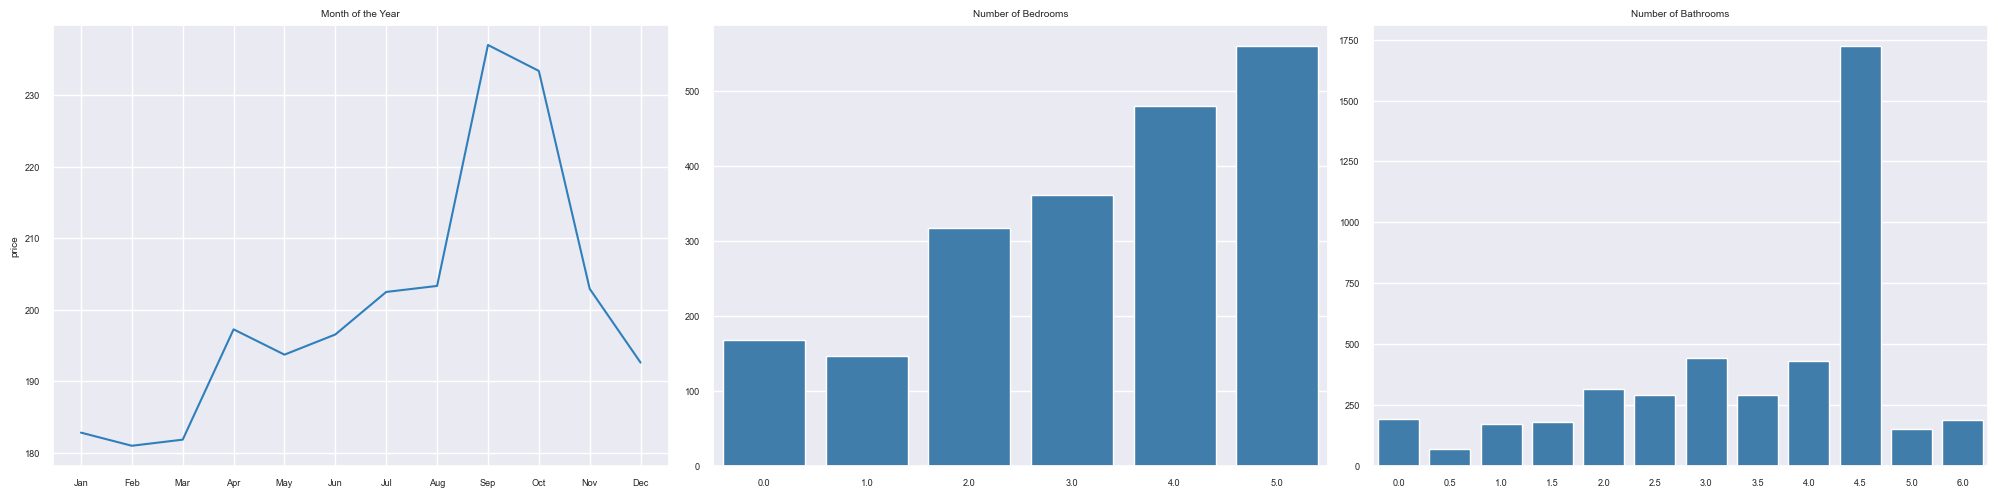

In [373]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Month plot
months = df_b.groupby("month").agg({"price": "mean"}).reset_index()

# sort by month
months.month = months.month.astype("category")
sorter = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
months.month = months.month.cat.set_categories(sorter)

sns.lineplot(
    x="month",
    y="price",
    data=months,
    color="#2F7FBC",
    ax=axs[0],
)
axs[0].set_title("Month of the Year")
axs[0].set_xlabel("")

# Bedrooms
bedrooms = df_b.groupby("bedrooms").agg({"price": "mean"}).reset_index()
sns.barplot(
    x="bedrooms", y="price", data=bedrooms, orient="v", color="#2F7FBC", ax=axs[1]
)
axs[1].set_title("Number of Bedrooms")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

# Bathrooms
bathrooms = df_b.groupby("bathrooms").agg({"price": "mean"}).reset_index()
sns.barplot(
    x="bathrooms", y="price", data=bathrooms, orient="v", color="#2F7FBC", ax=axs[2]
)
axs[2].set_title("Number of Bathrooms")
axs[2].set_xlabel("")
axs[2].set_ylabel("")

plt.tight_layout()
plt.show()


In [374]:
display(df_b.select_dtypes(include="object").sample(5))

,neighbourhood_cleansed,property_type,room_type,cancellation_policy,month
613999,Allston,Apartment,Private room,strict,Aug
52755,Jamaica Plain,Apartment,Private room,moderate,Aug
421080,Fenway,Apartment,Entire home/apt,moderate,Jun
535480,Dorchester,Apartment,Private room,moderate,Apr
513459,Dorchester,Apartment,Private room,strict,Dec


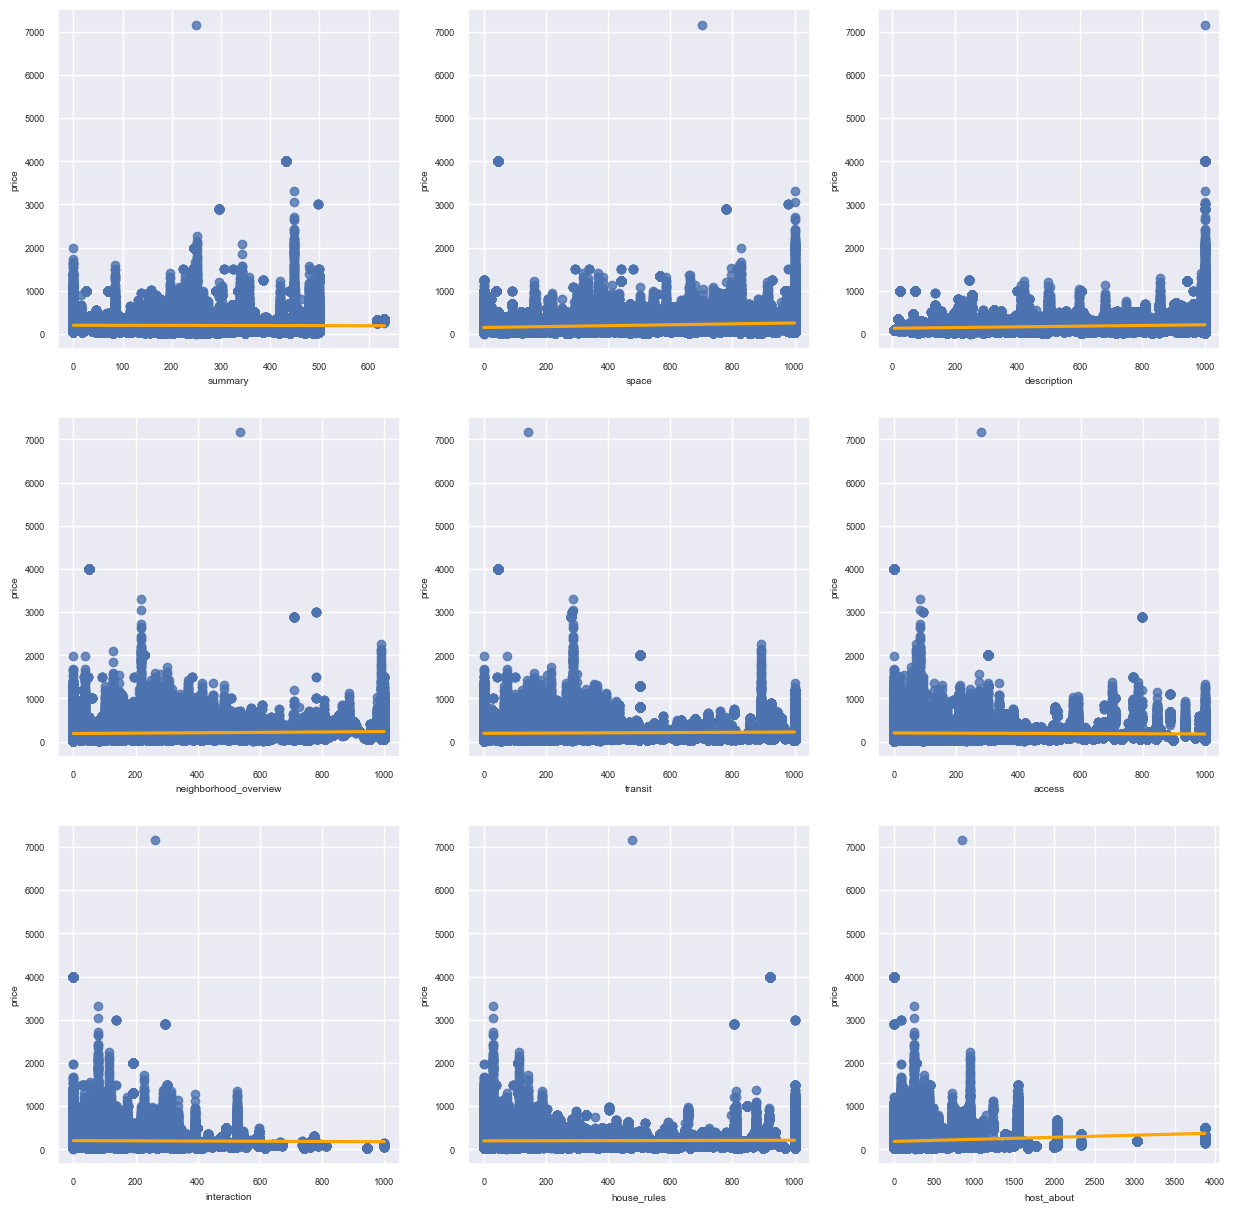

In [375]:
description_columns = [
    "summary",
    "space",
    "description",
    "neighborhood_overview",
    "transit",
    "access",
    "interaction",
    "house_rules",
    "host_about",
]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for feature, ax in zip(description_columns, axs.reshape(-1)):
    sns.regplot(
        x=feature, y="price", data=df_b, ax=ax, ci=None, line_kws={"color": "orange"}
    )

## 6 . Modeling


In [376]:
# create dummy columns
df_b = pd.get_dummies(
    df_b,
    columns=[
        "neighbourhood_cleansed",
        "property_type",
        "room_type",
        "cancellation_policy",
        "month",
    ],
)


In [377]:
# drop the id column
df_b = df_b.drop(labels=["id"], axis=1)

# drop the description columns
df_b = df_b.drop(labels=description_columns, axis=1)

# fill in the massing value
df_b = df_b.fillna(df_b.median())


In [378]:
display(df_b.sample(3))


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
333456,1.0,92.0,76.0,1,2,1.0,1.0,1.0,24,9.0,...,0,0,0,1,0,0,0,0,0,0
102016,4.0,96.0,68.0,0,5,2.0,2.0,3.0,2,10.0,...,0,0,0,0,0,0,0,1,0,0
361845,1.0,98.0,68.0,0,4,1.0,1.0,1.0,9,9.0,...,0,0,0,0,1,0,0,0,0,0


In [379]:
def find_optimal_lm_mod(
    df, response_col, cutoffs, test_size=0.30, random_state=42, plot=True
):
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        # reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        # split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            reduce_X, y, test_size=test_size, random_state=random_state
        )

        # fit the model and obtain pred response
        lm_model = LinearRegression()
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        # append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=0.8)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=0.8)
        plt.xlabel("Number of Features")
        plt.ylabel("Rsquared")
        plt.title("Rsquared by Number of Features")
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    # reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        reduce_X, y, test_size=test_size, random_state=random_state
    )

    # fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

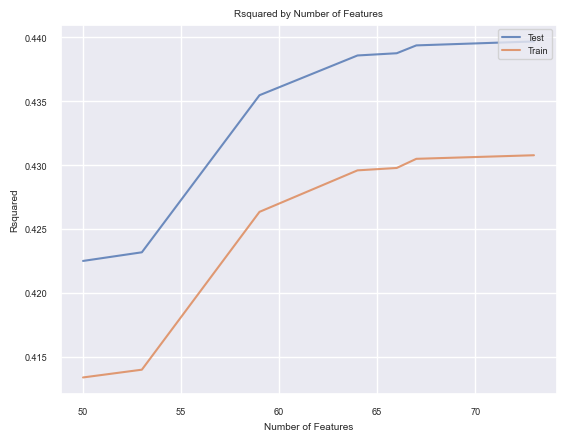

The rsquared on the training data was 0.4307905895758618.   The rsquared on the test data was 0.43969015445039095.


In [384]:
# Test your function with the above dataset
cutoffs = [20000, 15000, 10000, 5000, 3500, 2500, 1000, 100, 50]
(
    test_score,
    train_score,
    lm_model,
    X_train,
    X_test,
    y_train,
    y_test,
) = find_optimal_lm_mod(df_b, "price", cutoffs)

print(
    "The rsquared on the training data was {}.   The rsquared on the test data was {}.".format(
        max(train_score), max(test_score)
    )
)